 #                                   Final Project Deep Learning with Python
 ##                                               SoSe2024
 ###                                           Sotirios Gkosdis                                     
 ####                                    Sentiment Analysis for Mental Health Issues
 https://www.kaggle.com/datasets/parulpandey/emotion-dataset/data)

# Static embedding approach

The datatet for this task is imbalanced and the goal was the succefull multiclass classification. The static embedding method was approached and there are three models trained and evaluated. One where there is no balance in the data, the next one is the one that wasn't overfitting and the third one is the one that gathered the highest scores. The results are pointed out through the overview of the log information and their metrics, a plot and then with a classification report and its matrix.

In [7]:
import keras
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import nltk
import re




In [8]:
df = pd.read_csv('Combined Data.csv')

    Here was a problem with actually understanding the statements as the class and it wasnt accepting it as a string. Also there weren't many data-preprocessing tasks to do. While warking with this type of dataset I prefered to keep the punctiuation, because it's playing a semantical role and i didnt proceed to any stemmatization or lemmatization procedures in order not to mess the dataset. Also as I checked the datatset there were plenty emojis which had to be gone. for the static embedding methodology the punctiuation is getting removed from the TextVectorization that we performed for the static embedding it stays as it is. And the emoticon codes from stack-overflow.

    After getting to the bert model it cam to my knowledge that there were some 'ascii' characters that should be moved with some double spaces etc.. In a dataset that big its difficult to pay attention any single line with detail.

In [13]:
def emoji_cleaning(text):
    emojis = re.compile(
        "["
        u"\U0001F600-\U0001F64F"
        u"\U0001F300-\U0001F5FF"
        u"\U0001F680-\U0001F6FF"
        u"\U0001F1E0-\U0001F1FF"
        "]+", flags=re.UNICODE)
    text = emojis.sub(r'', text)
    text = re.sub(r'[â¤ï]', '', text)
    return text

def data_cleaning(data):
    if not isinstance(data, str):
        data = str(data)
    data = re.sub(r'&amp;[\w#]+', '', data)
    data = re.sub(r'\s+', ' ', data)
    data = emoji_cleaning(data)
    data = data.strip()
    return data

    Applying the data cleaning to the dataset

In [14]:
df['clean_data'] = df['statement'].apply(data_cleaning)
print(df)

       Unnamed: 0                                          statement   status  \
0               0                                         oh my gosh  Anxiety   
1               1  trouble sleeping, confused mind, restless hear...  Anxiety   
2               2  All wrong, back off dear, forward doubt. Stay ...  Anxiety   
3               3  I've shifted my focus to something else but I'...  Anxiety   
4               4  I'm restless and restless, it's been a month n...  Anxiety   
...           ...                                                ...      ...   
53038       53038  Nobody takes me seriously I’ve (24M) dealt wit...  Anxiety   
53039       53039  selfishness  "I don't feel very good, it's lik...  Anxiety   
53040       53040  Is there any way to sleep better? I can't slee...  Anxiety   
53041       53041  Public speaking tips? Hi, all. I have to give ...  Anxiety   
53042       53042  I have really bad door anxiety! It's not about...  Anxiety   

                           

    We want to count the values that are in the dataset and as i checked there were empty cells which had to be taken out

In [15]:
df['status'].value_counts()
df = df.dropna(axis= 0)


    We now count the unique labels that are in the dataset

In [16]:
df['status'].nunique()

7

    We now count the status values in order to use them later manually.

In [17]:
status_counts=df['status'].value_counts()
print(status_counts)

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


    I was struggling to enumerate tha labels automatically so I created a list of all of them and and then enumerate them in a dictionary with a key value relationship. After that we create a new list to the file that stores and maps these relationships and we keep the integers for later on.

In [18]:
labels = ['Normal', 'Depression', 'Suicidal', 'Anxiety', 'Bipolar', 'Stress', 'Personality disorder']
label_dict = {label: idx for idx, label in enumerate(labels)}
df['encoded_status'] = df['status'].map(label_dict)


    We use from the keras library the TextVectorization in order to tokenize and vectorize the data automatically together at the same time. Then we vectorize our data

In [19]:
from keras.layers import TextVectorization
from keras.utils import to_categorical


df['clean_data'] = np.vectorize(data_cleaning)(df['statement'])



    From taking the to_categorical from before we categorize the values of the classes. We create a new variable num_classes to use later and we set our parameters for the model. We create an other variable in the end to vectorize the values of statement data  later on. We want everything to turn into an integer. 

In [20]:
x = df['clean_data']
y = df[df.columns[3]].values

y = to_categorical(df['encoded_status'].values, num_classes=len(labels))
num_classes= len(labels)

MAX_WORDS = 20000
maxlen = 200
vectorizer = TextVectorization(max_tokens=MAX_WORDS, output_sequence_length=maxlen, output_mode='int')
vectorizer.adapt(x.values) 

    We perform the value vectorization and parsing it to all of  the data to learn the words as numaric variables while tokenixing them  
    

In [21]:
vectorized_data = vectorizer(x.values)
vectorized_data

<tf.Tensor: shape=(52681, 200), dtype=int64, numpy=
array([[ 607,    6, 4843, ...,    0,    0,    0],
       [ 927,  633,  954, ...,    0,    0,    0],
       [  32,  274,   92, ...,    0,    0,    0],
       ...,
       [  12,   70,   84, ...,    0,    0,    0],
       [1267, 1469,  992, ...,    0,    0,    0],
       [   2,   13,   59, ...,    0,    0,    0]])>

    We create a vocabulary for later on to use it for the embeddings and we print the lenght to be sure that everything is alright.

In [22]:
vocab = vectorizer.get_vocabulary()
print(len(vocab))

20000


    We start by genarating random numbers then we create an 1 dimension array of random indices and make it understandable for the model while saving them as tensors

In [23]:
np.random.seed(0)
indices = np.random.permutation(len(vectorized_data))
indices_tensor = tf.constant(indices, dtype=tf.int32)
print(indices_tensor)

tf.Tensor([ 2714 40124 35230 ... 42613 43567  2732], shape=(52681,), dtype=int32)


    In this part we gather the data and distinguish that 80 percent will be the training data an other 10 percent will be the validation data and finally the rest 10 percent will be the test data. After that we split the data for the right categories. And print the to visualize it. 

In [24]:
vectorized_data = tf.gather(vectorized_data, indices_tensor)
y = tf.gather(y, indices_tensor)

train_split = int(0.8 * len(vectorized_data))
val_split = int(0.9 * len(vectorized_data))

train_data, train_labels = vectorized_data[:train_split], y[:train_split]
val_data, val_labels = vectorized_data[train_split:val_split], y[train_split:val_split]
test_data, test_labels = vectorized_data[val_split:], y[val_split:]

print("Training Data shape :",(train_data.shape), " and Training labels: ", (train_labels.shape))
print("Validation Data shape :",(val_data.shape), " and Validation labels: ", (val_labels.shape))
print("Test Data shape :",(test_data.shape), " and Test labels: ", (test_labels.shape))

Training Data shape : (42144, 200)  and Training labels:  (42144, 7)
Validation Data shape : (5268, 200)  and Validation labels:  (5268, 7)
Test Data shape : (5269, 200)  and Test labels:  (5269, 7)


    This part as well as the next one i got them both from the slides. The real question was how many dimentions should i put in order not to make the model too complex nor too naive. i ve train the model with all the dimentions and almost all the possible scenarios that I could think in order to get the best results for the model. With this amount of dimentions I believe that are good and reasonable at the classification report.
    The emdeddings that I worked with were from Glove, the Wikipedia 2014 200 dimentions ones. Creating an empty dictionary we tell to our model then to store that in the first line we have the word and the rest are the embeddings for each word which are later saved in the dictionary.

In [25]:
glove_dir = 'compLing/students/courses/deepLearning24/finalProjects/sotirios.gkosdis/glove.6B.200d.txt'

embeddings_index = {}
with open(glove_dir, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


    We then create an other dictionaru for mapping the tokens to the right embedding. Since the dimentions of the embeddings that we added are 200 we have to declare it to our model. We then create an empty matrix to parse the embeddings to the vocabulary.

In [26]:
word_index = dict(zip(vocab, range(len(vocab))))
embedding_dim = 200

embedding_matrix = np.zeros((len(vocab), embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < len(vocab):
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    Since we saw the values from our labels we know that the model is probably going to overfit and the the predictions that is going to make are going to be biased. we create a Sequential model since its multiclass and not multilabel to need the model to predict more than one output. We parse the embeddings, the maximum number of words and provide it with an LSTM layer with 64 units. we perform categorical crossentropy as well we did to our other models because of the type of the classification we have. We use Adam as the optimizer as well to the other models because it's helping to reduce the validation loss in the evaluation.

In [27]:
from keras.layers import Embedding, Dense, LSTM
from keras.models import Sequential
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

model = Sequential()

model.add(Embedding(MAX_WORDS, embedding_dim, input_length=maxlen))
model.add(LSTM(64))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels, epochs=10, batch_size=64, validation_data=(val_data, val_labels))

test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test accuracy: ', test_acc)

model.summary()


Epoch 1/10


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


659/659 ━━━━━━━━━━━━━━━━━━━━ 63s 94ms/step - accuracy: 0.4256 - loss: 1.5257 - val_accuracy: 0.5676 - val_loss: 1.1337
Epoch 2/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 63s 96ms/step - accuracy: 0.5899 - loss: 1.0035 - val_accuracy: 0.6595 - val_loss: 0.8173
Epoch 3/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 63s 96ms/step - accuracy: 0.7027 - loss: 0.7181 - val_accuracy: 0.7025 - val_loss: 0.7507
Epoch 4/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 65s 98ms/step - accuracy: 0.7778 - loss: 0.5786 - val_accuracy: 0.7202 - val_loss: 0.7265
Epoch 5/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 64s 97ms/step - accuracy: 0.8562 - loss: 0.4048 - val_accuracy: 0.7565 - val_loss: 0.6832
Epoch 6/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 64s 98ms/step - accuracy: 0.8991 - loss: 0.2975 - val_accuracy: 0.7585 - val_loss: 0.7291
Epoch 7/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 65s 98ms/step - accuracy: 0.9289 - loss: 0.2209 - val_accuracy: 0.7464 - val_loss: 0.8036
Epoch 8/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 65s 98ms/step - accuracy: 0.9475 - loss: 0.1643 - val_accurac

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 200)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        67,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,204,887 (46.56 MB)

 Trainable params: 4,068,295 (15.52 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,136,592 (31.04 MB)

    Using the plot that was given from the class but changing the colours only for better visualization, we understand that, this model seems to be overfitting. We observe that the accuracy of the training data is getting high but the accuracy of the test data is much lower in the final epoch. It's being observed that the overfitting starts from the Epoch 6. Althought the accuracy from the first expirement isn't the best, they were expected because the dataset is imbalanced.

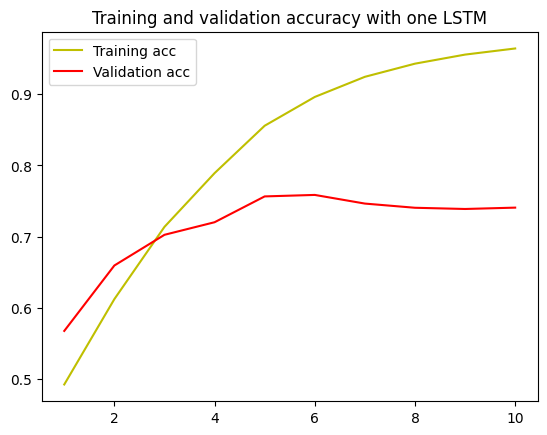

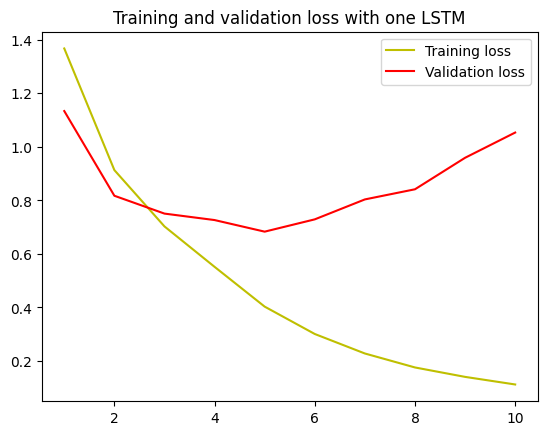

In [28]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y-', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Validation acc')
plt.title('Training and validation accuracy with one LSTM')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'y-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss with one LSTM')
plt.legend()

plt.show()

    The classification report isn't doing well confution matrix shows that its right, despite the discent accuracy it seems that the predictions are biased and in classes with more samples it seems to be doing fine and in classes with less its performing poorely. This means that it tends to missclasiffy the test results and make false predictions for untrained classes.

In [29]:
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(test_labels, axis=1)

print(classification_report(true_classes, predicted_classes))

print(confusion_matrix(true_classes, predicted_classes))

165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1663
           1       0.70      0.68      0.69      1531
           2       0.64      0.64      0.64      1051
           3       0.71      0.80      0.75       396
           4       0.77      0.79      0.78       247
           5       0.56      0.53      0.54       265
           6       0.55      0.47      0.50       116

    accuracy                           0.75      5269
   macro avg       0.69      0.69      0.69      5269
weighted avg       0.75      0.75      0.75      5269

[[1537   33   21   28    4   32    8]
 [  47 1035  347   22   30   32   18]
 [  41  323  674    3    2    5    3]
 [  19   23    1  315   12   23    3]
 [   3   16    2   20  195    4    7]
 [  40   26    5   46    2  141    5]
 [   7   19    1   10    9   16   54]]


     We reshape the model for visualization.

In [30]:
train_data.shape, train_labels.shape

(TensorShape([42144, 200]), TensorShape([42144, 7]))

    We import sklearn to compute the weights for the classes in order not to be missbalanced. I experimented with different methods using, oversampling, undersamling and hybrid sampling, ending to the conclustion that this is the most reasonable solution for our dataset and the numbers we have in different classes. 
    I created an variable for storing the unique classes for each label. then we map the varaibles to the weights, we sort it to have it tied up and print the result. We will perform it to the next model as well.

In [31]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced',
                                     classes=np.unique(df['status']),
                                     y=df['status'].values)
class_weights_dict = {i : class_weights[i] for i in range(len(np.unique(df['status'])))}

class_weights.sort()
class_weights
class_weights = dict(enumerate(class_weights))

print(class_weights)

{0: 0.4604942264490695, 1: 0.48856512223170234, 2: 0.7065205729306367, 3: 1.9593483839773869, 4: 2.710067390297855, 5: 2.909105969407477, 6: 6.987796790025202}


    For this example we tried every single sollution that we could in order not to overfit. Untill Epoch 9 wich was the less vallidation loss the model was the only one not overfitting but the performance in both metrics and Classicication report i super poor. we added dropout both to embeddings layer and to the model one. We applied the l2 regulazer in order to generalize even more adn we increased the models complexity. But It wasnt enough. After some epochs the model was overfitting and the performanc ewas still lower than the one from the training set.
    for this occation we also included the weight from before in order not to let the model make biased decisions and create a balance. for this occation it wasn't proven. 

In [32]:
from keras.layers import Embedding, Dense, LSTM, Dropout, BatchNormalization
from keras.models import Sequential
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2

model = Sequential()
model.add(Embedding(MAX_WORDS, embedding_dim, input_length=maxlen))
model.add(Dropout(0.3))
model.add(LSTM(128, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')


history = model.fit(train_data, train_labels, epochs=10, batch_size=64, validation_data=(val_data, val_labels), class_weight=class_weights, callbacks=[early_stopping, model_checkpoint])

test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test accuracy: ', test_acc)
model.summary()


Epoch 1/10


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


659/659 ━━━━━━━━━━━━━━━━━━━━ 120s 180ms/step - accuracy: 0.2818 - loss: 2.3780 - val_accuracy: 0.3605 - val_loss: 1.8554
Epoch 2/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.2341 - loss: 1.9346 - val_accuracy: 0.3286 - val_loss: 1.8840
Epoch 3/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.2539 - loss: 1.9140 - val_accuracy: 0.3404 - val_loss: 1.5418
Epoch 4/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 118s 179ms/step - accuracy: 0.3486 - loss: 1.7177 - val_accuracy: 0.3254 - val_loss: 1.5190
Epoch 5/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.3392 - loss: 1.6773 - val_accuracy: 0.3244 - val_loss: 1.5455
Epoch 6/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.3573 - loss: 1.6495 - val_accuracy: 0.4675 - val_loss: 1.3708
Epoch 7/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.5054 - loss: 1.4233 - val_accuracy: 0.5729 - val_loss: 1.0859
Epoch 8/10
659/659 ━━━━━━━━━━━━━━━━━━━━ 119s 180ms/step - accuracy: 0.6031 - loss: 1.08

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 200, 200)       │     4,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200, 200)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       168,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,508,055 (47.71 MB)

 Trainable params: 4,169,351 (15.90 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,338,704 (31.81 MB)

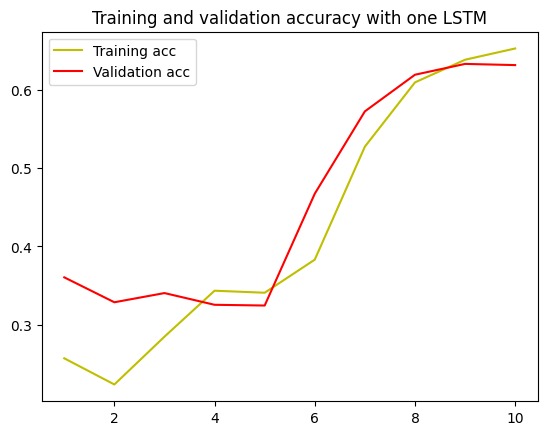

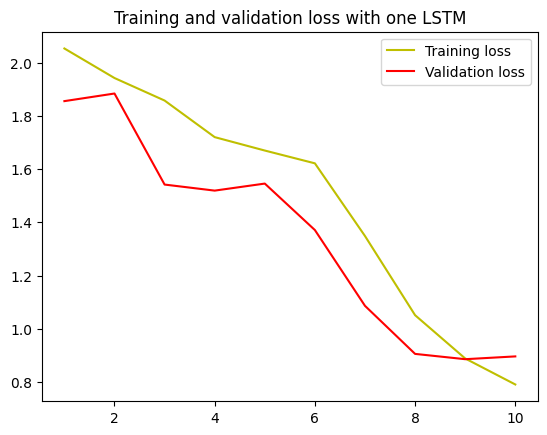

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y-', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Validation acc')
plt.title('Training and validation accuracy with one LSTM')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'y-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss with one LSTM')
plt.legend()

plt.show()

In [34]:
predictions = model.predict(train_data)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(train_labels, axis=1)

print(classification_report(true_classes, predicted_classes))

print(confusion_matrix(true_classes, predicted_classes))

1317/1317 ━━━━━━━━━━━━━━━━━━━━ 49s 37ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94     13054
           1       0.66      0.27      0.38     12342
           2       0.47      0.75      0.58      8507
           3       0.72      0.88      0.79      3103
           4       0.89      0.78      0.83      2227
           5       0.47      0.66      0.55      2066
           6       0.34      0.87      0.48       845

    accuracy                           0.67     42144
   macro avg       0.64      0.73      0.65     42144
weighted avg       0.71      0.67      0.66     42144

[[12133    70    50   171    18   547    65]
 [  235  3337  7082   236   107   490   855]
 [  300  1552  6393    22    16   106   118]
 [   44    17     3  2729    29   247    34]
 [    7    15     2    30  1728   110   335]
 [    9    38     3   582    15  1365    54]
 [    2    14     4    12    34    42   737]]


    For the last model we kept the same neurons and the same dropouts but as we tested the l2 regulizer was messing the results in order to avoid overfittng. The performance is identicall to th eperformance of the model with 256 units as tested. The modle while havinf the weights and not the regulizer it is still overfitting after 5th epoch as we see from the results. from the overview metrics and the plot. Although the model according to the confusion matrix it seems to be in a more advanced level from before the weights not only because of the increased complexity but also from the weights that are used. while still trying to make it not overfit.

In [ ]:
model = Sequential()
model.add(Embedding(MAX_WORDS, embedding_dim, input_length=maxlen))
model.add(Dropout(0.3))
model.add(LSTM(128))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, mode='min')


history = model.fit(train_data, train_labels, epochs=10, batch_size=64, validation_data=(val_data, val_labels), class_weight=class_weights, callbacks=[early_stopping, model_checkpoint])

test_loss, test_acc = model.evaluate(test_data, test_labels)
print('Test accuracy: ', test_acc)
model.summary()

Epoch 1/10


/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


257/659 ━━━━━━━━━━━━━━━━━━━━ 1:10 175ms/step - accuracy: 0.2690 - loss: 1.9170

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'y-', label='Training acc')
plt.plot(epochs, val_acc, 'r-', label='Validation acc')
plt.title('Training and validation accuracy with one LSTM')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'y-', label='Training loss')
plt.plot(epochs, val_loss, 'r-', label='Validation loss')
plt.title('Training and validation loss with one LSTM')
plt.legend()

plt.show()

In [ ]:
predictions = model.predict(train_data)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.argmax(train_labels, axis=1)

print(classification_report(true_classes, predicted_classes))

print(confusion_matrix(true_classes, predicted_classes))

## Conclusion

While trying to figure out what is going on and how can we not have overfitting but good results, I tried almost every single solution that i was capable of and fugured out or knew. The worst performance that the model had was with the hybrid-sampling in both classification report and the model metrics. The most remarkable of the case and really suspitious is that the best Accuracy score that the model had while overfitting of course was wit oversampling at 64 units and not with a strategy created byme, but with minority strategy. The model was able to reach the 0.91 in accuracy while retaning all the prices higher than expected, given that SMOTE minority is actually a strategy given for imbalanced datasets for binary classification. 

Given the cirqumstances for the dataset, the combination of both good metrics and accuracy wasn't applicable and the frustration was growing, there where pages like the following two, who gave me hope.